# Classifying SMSs as Spam using Deep Learning

- Basic Imports
- Load and perform EDA on our dataset
- Data Preprocessing
- Split training and testing data
- Build models
- Evaluate and compare different models
- Save the best model


## Basic Imports


In [114]:
# Libraries for EDA and data preprocessing
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Library for splitting data into training and testing data

# Deep Learning Libraries for text Pre-Processing

# Modeling


## Loading Data


In [115]:
messages = pd.read_csv('spam.csv', encoding='latin1')
messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)


In [116]:
messages.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)


`Getting some basic information about our data`


In [117]:
# Let's get some information about our dataset

messages.shape, messages.describe()


((5572, 2),
        label                 message
 count   5572                    5572
 unique     2                    5169
 top      ham  Sorry, I'll call later
 freq    4825                      30)

In [118]:
# Checking for duplicates and NaN values
messages.duplicated().sum(), messages.isna().sum()


(403,
 label      0
 message    0
 dtype: int64)

In [119]:
# Get all the ham and spam messages
ham_msg = messages[messages.label == 'ham']
spam_msg = messages[messages.label == 'spam']

ham_msg, spam_msg


(     label                                            message
 0      ham  Go until jurong point, crazy.. Available only ...
 1      ham                      Ok lar... Joking wif u oni...
 3      ham  U dun say so early hor... U c already then say...
 4      ham  Nah I don't think he goes to usf, he lives aro...
 6      ham  Even my brother is not like to speak with me. ...
 ...    ...                                                ...
 5565   ham                                       Huh y lei...
 5568   ham              Will Ì_ b going to esplanade fr home?
 5569   ham  Pity, * was in mood for that. So...any other s...
 5570   ham  The guy did some bitching but I acted like i'd...
 5571   ham                         Rofl. Its true to its name
 
 [4825 rows x 2 columns],
      label                                            message
 2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
 5     spam  FreeMsg Hey there darling it's been 3 week's n...
 8     spam  WINNER!! As a 

### `Creating strings to pass to WordCloud`


In [120]:
# Creating numpy lists to visualize ham and spam messages using WordCloud
# We made a combined string of all the messages in ham and spam labels
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())


#### `Creating a custom fucntion for plotting word clouds`


In [121]:

def plot_wordcloud(msg_text):
    msg_wordcloud = WordCloud(width=500, height=250, stopwords=STOPWORDS, max_font_size=50,
                              background_color='black', colormap='Blues').generate(msg_text)
    plt.figure(figsize=(10, 10), facecolor='white')
    plt.imshow(msg_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


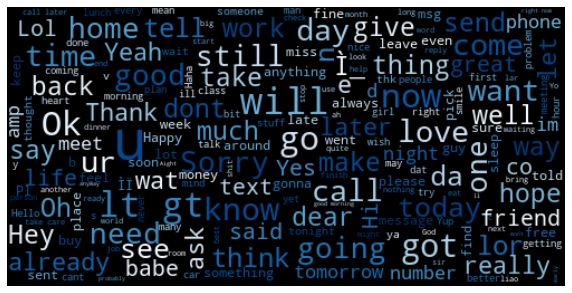

In [122]:
# Word CLoud for ham messages
plot_wordcloud(ham_msg_text)


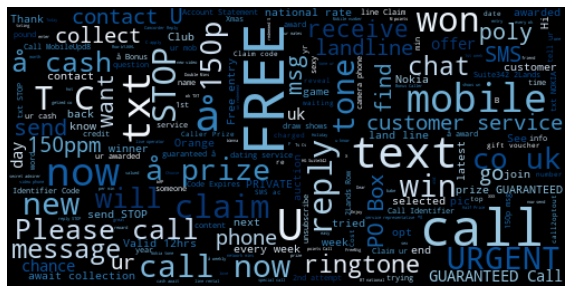

In [123]:
# Word CLoud for spam messages
plot_wordcloud(spam_msg_text)


<AxesSubplot:xlabel='label', ylabel='count'>

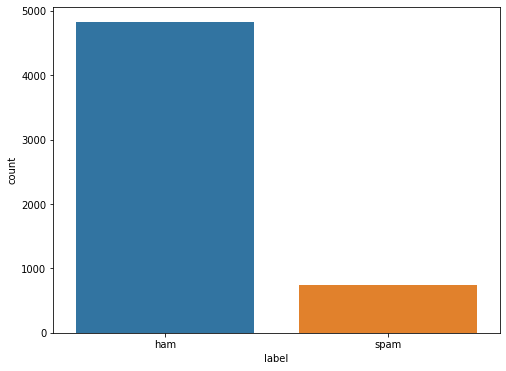

In [124]:
# We can observe imbalance data here
plt.figure(figsize=(8, 6), facecolor='white')
sns.countplot(x='label', data=messages)


### We are going to encounter this imbalance by using the downsampling technique

In [125]:
ham_msg_df  =ham_msg.sample(n=len(spam_msg), random_state=44)
spam_msg_df = spam_msg
ham_msg_df.shape,spam_msg_df.shape

((747, 2), (747, 2))

Text(0.5, 0, 'Message types')

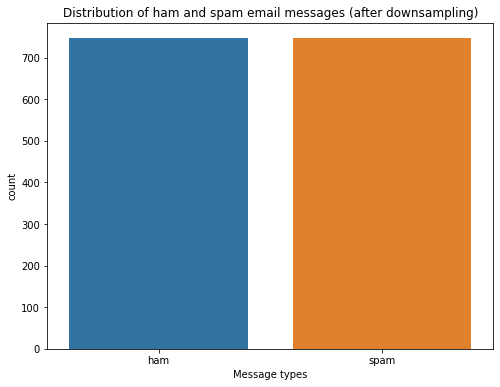

In [126]:
# Creating a new message dataframe
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6),facecolor='white')
sns.countplot(x ='label',data=msg_df)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [127]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels,msg_df

(       text_length
 label             
 ham      69.626506
 spam    138.866131,
      label                                            message  text_length
 0      ham                             Yes, princess. Toledo.           22
 1      ham  Dude while were makin those weirdy brownies my...           88
 2      ham  Hiya, sorry didn't hav signal. I haven't seen ...          169
 3      ham  Then u ask darren go n pick u lor... But i oso...           74
 4      ham  Lol no. I just need to cash in my nitros. Hurr...           75
 ...    ...                                                ...          ...
 1489  spam  Want explicit SEX in 30 secs? Ring 02073162414...           90
 1490  spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...          160
 1491  spam  Had your contract mobile 11 Mnths? Latest Moto...          160
 1492  spam  REMINDER FROM O2: To get 2.50 pounds free call...          147
 1493  spam  This is the 2nd time we have tried 2 contact u...          161
 
 [149

## Preparing Train and Test Data

In [128]:
# ham :- 0
# spam :- 1

msg_df['msg_type'] = msg_df['label'].map({'ham':0,'spam':1})
msg_label = msg_df['msg_type'].values

# Splitting into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],msg_label, test_size=0.2, random_state=434)

In [129]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [130]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [131]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [132]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [133]:
print(len(training_padded[0]))

50


In [134]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

## Creating our model

In [135]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [136]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

## Compiling our model

In [137]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

## Fitting our model

In [138]:
# Fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6866 - accuracy: 0.5339 - val_loss: 0.6758 - val_accuracy: 0.6990 - 620ms/epoch - 16ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6590 - accuracy: 0.7950 - val_loss: 0.6370 - val_accuracy: 0.7893 - 58ms/epoch - 2ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6025 - accuracy: 0.8552 - val_loss: 0.5675 - val_accuracy: 0.8395 - 63ms/epoch - 2ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5168 - accuracy: 0.8787 - val_loss: 0.4798 - val_accuracy: 0.8729 - 63ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4199 - accuracy: 0.8921 - val_loss: 0.3979 - val_accuracy: 0.8796 - 55ms/epoch - 1ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3429 - accuracy: 0.9038 - val_loss: 0.3352 - val_accuracy: 0.8863 - 103ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2898 - accuracy: 0.9113 - val_loss: 0.2858 - val_accuracy: 0.8997 - 176ms/epoch - 5ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2463 - accuracy: 0.9247 - val_loss: 0.2446 - val_accuracy: 0.9130 - 167ms/epoch - 4ms/step
Epoch 9/30
38/38 - 

## Evaluating the model

In [139]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9732


[0.07937023043632507, 0.9732441306114197]

In [140]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

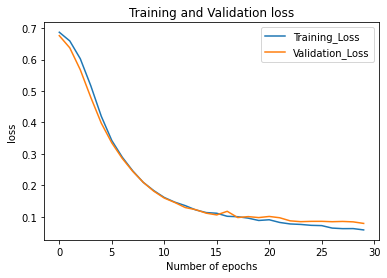

In [141]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

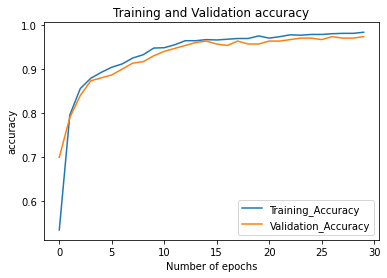

In [142]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [145]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))


1/1 [==============================] - 0s 25ms/step


array([[0.01955922]], dtype=float32)

In [146]:
model.save('spam_classifier')

INFO:tensorflow:Assets written to: spam_classifier\assets
